In [2]:
import sys 
sys.path.append("../../")
import torch
import torch.optim as optim

import numpy as np
from tqdm import tqdm, tqdm_notebook
from sklearn.decomposition import PCA, TruncatedSVD
#from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

import matplotlib.pyplot as plt
#plt.style.use('dark_background')


from src.models.medical_codes_rnn import McRnn

from src.utils.model_utils import plot_history, confusion, precision, recall, F1

%load_ext autoreload
%autoreload 2

In [ ]:
path2model = 'results/exps/exp_2019-06-13_00:37:12_max_len-400_task-0.5_pred_layer-last_hidden.pt'
checkpoint = torch.load(path2model)
model_args =  checkpoint['model_args']
model = McRnn(**model_args)
optimizer = optimizer = optim.SGD(model.parameters(), lr=0.1)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss_history = checkpoint['train_loss_history']
dev_loss_history = checkpoint['dev_loss_history']

In [ ]:
word2ix = model_args['vocab']
ix2word = {v: k for (k, v) in word2ix.items()}
# extract the embeddings from the model
embeddings = model.embeddings.weight.detach().numpy()
embeddings.shape

# Reduction de dimension

In [ ]:
pca = PCA(n_components=2)
Xpca = pca.fit_transform(embeddings)
X = Xpca

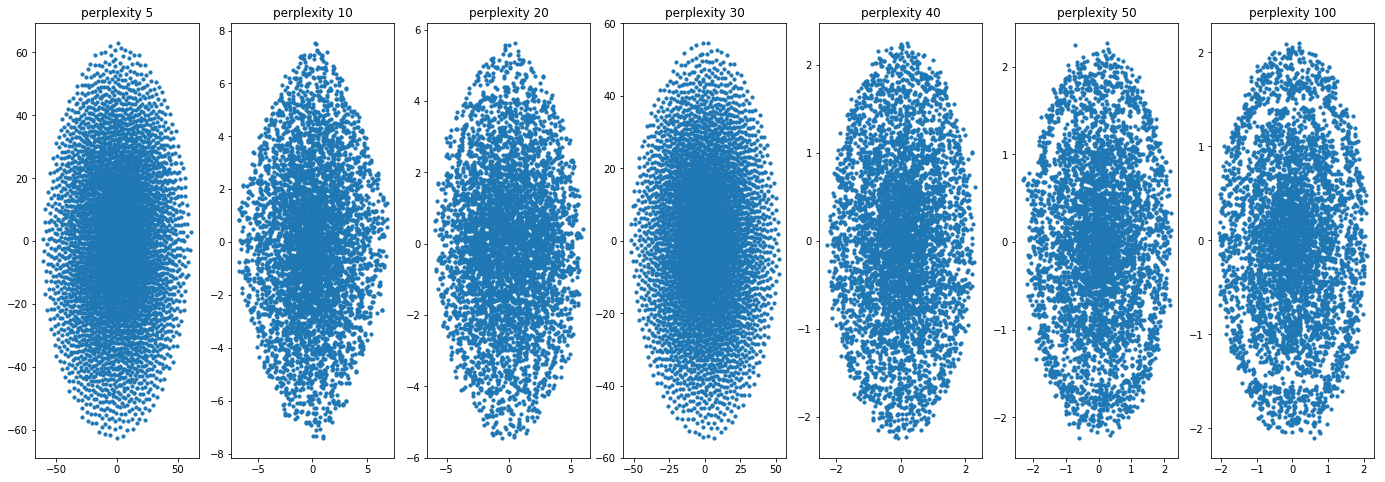

In [28]:
# Searching some satistfaying perplexity parameter
perplexities = [5, 10, 20, 30, 40, 50, 100]
n_jobs=50
fig, axes = plt.subplots(nrows=1, ncols=len(perplexities), figsize=(24, 8))
for ax, p in zip(axes, perplexities):
    #fig = plt.figure(figsize=(10,10))
    #plt.subplots_adjust(bottom = 0.1)
    tsne = TSNE(n_components=2, metric='cosine', perplexity=p, n_jobs=n_jobs)
    X = tsne.fit_transform(embeddings)
    ax.scatter(X[:, 0], X[:, 1], marker='o', s=10)
    ax.set_title("perplexity {}".format(p))
    
plt.show()

# Visualisation

In [ ]:
tsne = TSNE(n_components=2, metric='cosine', perplexity=40, n_jobs=40)
X = tsne.fit_transform(embeddings)

In [ ]:
from bokeh.plotting import figure, output_file, show, save
from bokeh.models import ColumnDataSource, HoverTool#LabelSet, Label
#from bokeh.io import output_notebook
import numpy as np

In [39]:
# get labels
import pandas as pd
path2nomenclatures = '/home/commun/echange/matthieu_doutreligne/nomenclatures/nomenclatures_for_susana/'
path2irpha =  '/home/commun/echange/matthieu_doutreligne/nomenclatures/external_nomenclatures/IR_PHA_R.csv'
path2cim = path2nomenclatures + 'cim_10_joined.csv'
path2ccam = path2nomenclatures + 'ccam_joined.csv'

nomenclatures = {
    'ccam': pd.read_csv(path2ccam), 'cim10': pd.read_csv(path2cim), 'pharma': pd.read_csv(path2irpha, sep=';')}

code_len2type = {3:'diagnostic', 4:''}
def get_libelle(nomenclatures, event_codes):
    libelles = []
    event_types = []
    for code in event_codes:
        code_len = len(code)
        try:
            event_type = code_len2type(code_len)
        except:
            print(len(code), code)
        if len(code) == 3:
            nom = nomenclatures['cim10']
            lib = nom.loc[nom[]]
        
        event_types.append(event_type)
        libelles.append(lib)
    return libelles, event_types

/home/matthieu.doutreligne/.conda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Interactive plot

In [31]:
output_file('color_scatter.html', title='color_scatter example', mode='inline')

data = X
N = data.shape[0]
indices = np.arange(0, N)
subset = np.random.choice(indices, 1000, replace=False)
label_texts = list(ix2word.values())
source = ColumnDataSource(data=dict(x=data[:,0], y=data[:, 1], code=label_texts))

hover = HoverTool(tooltips=[('Code', '@code')])
TOOLS=[hover, "crosshair, pan, wheel_zoom, zoom_in, zoom_out, box_zoom, undo, reset, tap, save, box_select, poly_select, lasso_select"]
p = figure(tools=TOOLS, title='Inspecting embeddings', plot_width=1400, plot_height=800)

p.scatter(x='x', y='y', source=source)
#labels = LabelSet(x='x', y='y', text='code', level='glyph', x_offset=5, y_offset=5, source=source, render_mode='canvas')
#p.add_layout(labels)

save(p)

'/home/matthieu.doutreligne/deep_trajectories/studies/bpco_crisis/color_scatter.html'

### Static

In [6]:
SAVE = False

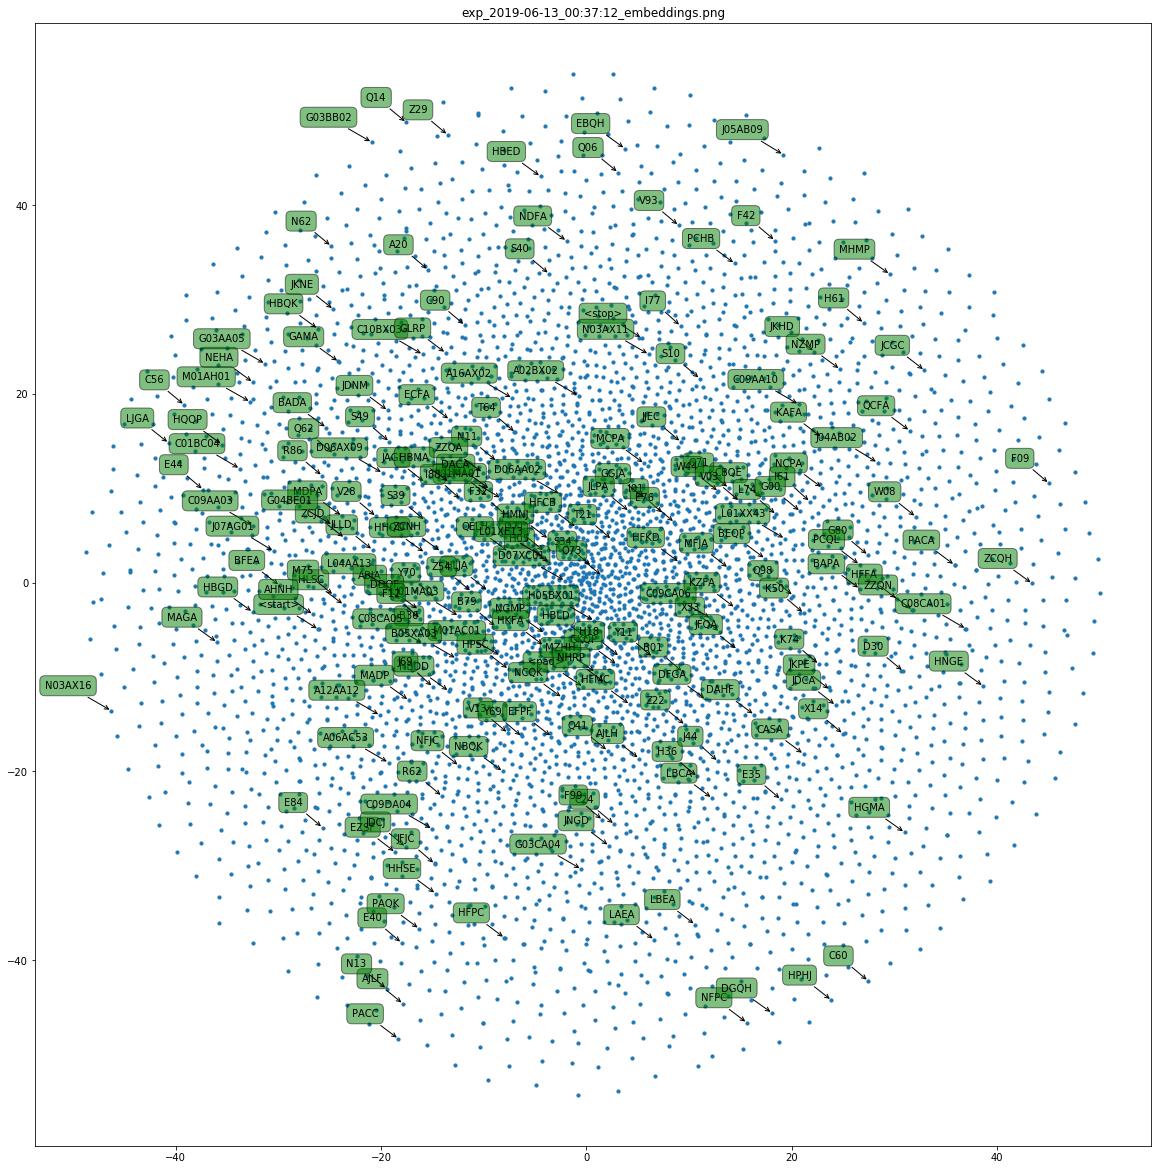

In [7]:
img_name =  path2model.split('/')[-1].split('max')[0] + 'embeddings.png'
data = X
N = data.shape[0]
indices = np.arange(0, N)
subset = np.random.choice(indices, 200, replace=False)

labels = list(ix2word.values())
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    X[:, 0], X[:, 1], marker='o', s=10,
    #cmap=plt.get_cmap('Spectral')
    )

for label, x, y in zip(labels, X[subset, 0], X[subset, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='green', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.title(img_name)
if SAVE:
    plt.savefig('results/imgs/{}'.format(img_name))
plt.show()